Story - 2 : Can the FED Control Inflation and Maintain Full Employment
The Federal Reserve's mandate from Congress is to control inflation and to maintain low unemployment. These seem to be contradictory objectives.
For this story you will need to source the following data for the last 25 years;
* The Consumer Price Index (CPI) (Bureau of Labor Statistics)

* The FED Funds Rate (FRED) (Federal Reserve Board)

* Unemployment Rate  (Bureau of Labor Statistics)

Your Data Visualizations should be designed to answer the question "Has the FED been able to fulfill the mandate given to it by Congress?"
Notes:
You must use a different application or library to create your visualization(s) from what you used for Story -1 (e.g. If you used Excel for Story -1 you may not use it for this story)

You will receive 20 bonus point if you access the data through available APIs using code that you develop

Remember, the FED raises rate after reviewing the CPI and other data and unemployment (layoffs) occur after company operating costs go up.

This assignment is due at the end of week four of the semester

### Load Libraries

In [649]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
import numpy as np
import getpass
import re, datetime

### Load API Key

In [39]:
fed_api_key = getpass.getpass("Submit FED API key:")

Submit FED API key:········


### Pull relevant data via API & Preliminary Review

In [177]:
def pull_bls_data(start,end):
    headers = {'Content-type': 'application/json'}
    data_cpi = json.dumps({"seriesid": ['CUSR0000SA0'],"startyear":f"{start}", "endyear":f"{end}"})
    data_unemp = json.dumps({"seriesid": ['LNS14000000'],"startyear":f"{start}", "endyear":f"{end}"})
    cpi = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data_cpi, headers=headers)
    unemp = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data_unemp, headers=headers)
    return json.loads(cpi.text),json.loads(unemp.text)

In [179]:
rngs = [x for x in range(0,30,5)]
bls_data = [pull_bls_data(start=1998+rngs[val],end=1998+rngs[val+1]) for val in range(len(rngs)) if val<5]

In [314]:
fed_input = [('1998-01-01','2008-12-31'),('2009-01-01','2017-12-31'),('2018-01-01','2023-09-01')]
fed_list = []
for (idx,dt) in enumerate(fed_input):
    fed_data = requests.get(f'https://api.stlouisfed.org/fred/series/observations?series_id=DFF&api_key={fed_api_key}&observation_start={dt[0]}&observation_end={dt[1]}&file_type=json').json()
    fed_list.extend([(x['date'],x['value']) for x in fed_data['observations']])
fed_df = pd.DataFrame(fed_list,columns=['measure_date','fed_eff_rate'])
fed_df.shape

(9375, 2)

In [627]:
print(fed_df['measure_date'].min())
fed_df.head()

1998-01-01


,measure_date,fed_eff_rate,Date,Measure
0,1998-01-01,5.840,1998-01-01,5.84
1,1998-01-02,6.060,1998-01-02,6.06
2,1998-01-03,6.060,1998-01-03,6.06
3,1998-01-04,6.060,1998-01-04,6.06
4,1998-01-05,5.510,1998-01-05,5.51


In [642]:
fed_df.dtypes

measure_date            object
fed_eff_rate            object
Date            datetime64[ns]
Measure                float64
dtype: object

In [317]:
fed_df.loc[:,'Date'] = fed_df['measure_date'].astype('datetime64[ns]')
fed_df.loc[:,'Measure'] = pd.to_numeric(fed_df['fed_eff_rate'])

In [219]:
def flatten_lists(input_list):
    '''Sourced from (Real Python)[https://realpython.com/python-flatten-list/#using-a-comprehension-to-flatten-a-list-of-lists]'''
    return [item for row in input_list for item in row]

In [223]:
df = pd.DataFrame()
for idx,x in enumerate(bls_data):
    cpi_base = [y['data'] for y in x[0]['Results']['series']]
    cpi_rev = flatten_lists(cpi_base)
    unemp_base = [y['data'] for y in x[1]['Results']['series']]
    unemp_rev = flatten_lists(unemp_base)
    cpi_df = pd.DataFrame(cpi_rev,columns=['year','period','periodName','value','footnotes'])
    cpi_df.loc[:,'Measure'] = 'CPI'
    unemp_df = pd.DataFrame(unemp_rev,columns=['year','period','periodName','value','footnotes'])
    unemp_df.loc[:,'Measure'] = 'Unemployment Rate'
    df = pd.concat([df,cpi_df,unemp_df])

0
1
2
3
4


In [226]:
df.groupby(['Measure'])['year'].agg(['min','max','count'])

,min,max,count
Measure,,,
CPI,1998,2023,356
Unemployment Rate,1998,2023,356


In [253]:
bls_data_df[bls_data_df.value.str.contains('[^\d.]', regex= True, na=False)]

,year,period,periodName,value,footnotes,Measure,Month_Num,Month,Date


### Data Wrangling and Data Type Validation

In [268]:
mnth_test = [[1,'January'],[2,'February'],[3,'March'],[4,'April'],[5,'May'],[6,'June'],[7,'July'],[8,'August'],[9,'September'],[10,'October'],[11,'November'],[12,'December']]
df_mnth_test = pd.DataFrame(mnth_test,columns=['Month_Num','Month'])
bls_data_df = pd.merge(df,df_mnth_test,how='left',left_on='periodName',right_on='Month')
bls_data_df.loc[:,'value_num'] = pd.to_numeric(bls_data_df['value'])
bls_data_df.loc[:,'Date'] = bls_data_df.apply(lambda row: row['year'] + "-"+str(row['Month_Num']).zfill(2)+'-01',axis=1).astype('datetime64[ns]')
bls_data_df.head()

,year,period,periodName,value,footnotes,Measure,Month_Num,Month,value_num,Date
0,2003,M12,December,185.5,[{}],CPI,12,December,185.5,2003-12-01
1,2003,M11,November,185.0,[{}],CPI,11,November,185.0,2003-11-01
2,2003,M10,October,184.9,[{}],CPI,10,October,184.9,2003-10-01
3,2003,M09,September,185.1,[{}],CPI,9,September,185.1,2003-09-01
4,2003,M08,August,184.5,[{}],CPI,8,August,184.5,2003-08-01


In [271]:
bls_data_df[bls_data_df['Measure']=='CPI']['value'].agg(['min','max'])
bls_data_df.groupby('Measure').describe()

Month_Num                                                \
                      count      mean       std  min  25%  50%  75%   max   
Measure                                                                     
CPI                   356.0  6.455056  3.447915  1.0  3.0  6.0  9.0  12.0   
Unemployment Rate     356.0  6.455056  3.447915  1.0  3.0  6.0  9.0  12.0   

                  value_num                                                   \
                      count        mean        std    min      25%       50%   
Measure                                                                        
CPI                   356.0  220.601615  34.860718  162.0  188.725  219.3125   
Unemployment Rate     356.0    5.692135   1.857833    3.4    4.300    5.2000   

                                      
                        75%      max  
Measure                               
CPI                244.0045  306.269  
Unemployment Rate    6.5000   14.700

In [266]:
bls_data_df.dtypes

year                  object
period                object
periodName            object
value                 object
footnotes             object
Measure               object
Month_Num              int64
Month                 object
Date          datetime64[ns]
dtype: object

### Visualizations
#### Has the FED been able to fulfill the mandate given to it by Congress?

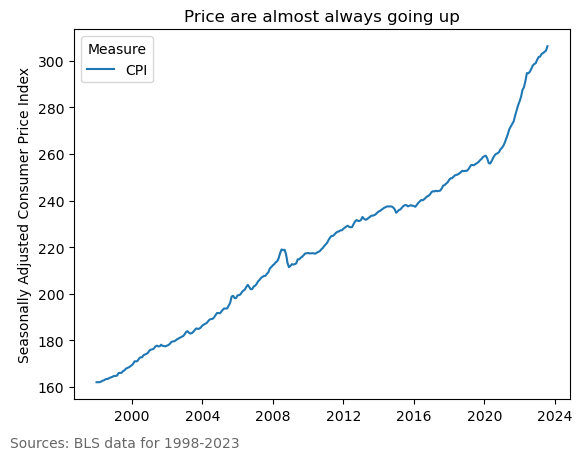

In [636]:
sns.lineplot(data=bls_data_df[bls_data_df['Measure']=='CPI'],x='Date',y='value_num',hue='Measure')
plt.title('Price are almost always going up')
plt.ylabel('Seasonally Adjusted Consumer Price Index')
plt.xlabel('')
plt.figtext(0.025, 0.01, 'Sources: BLS data for 1998-2023', fontsize=10, ha='left',alpha=0.6)
plt.show();

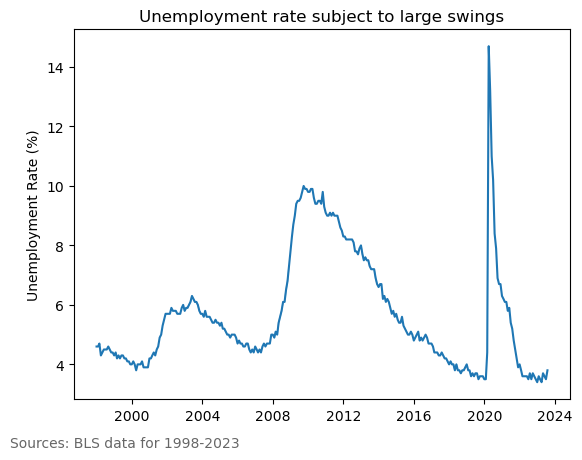

In [638]:
sns.lineplot(data=bls_data_df[bls_data_df['Measure']=='Unemployment Rate'],x='Date',y='value_num')
plt.title('Unemployment rate subject to large swings')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('')
plt.figtext(0.025, 0.01, 'Sources: BLS data for 1998-2023', fontsize=10, ha='left',alpha=0.6)
plt.show();

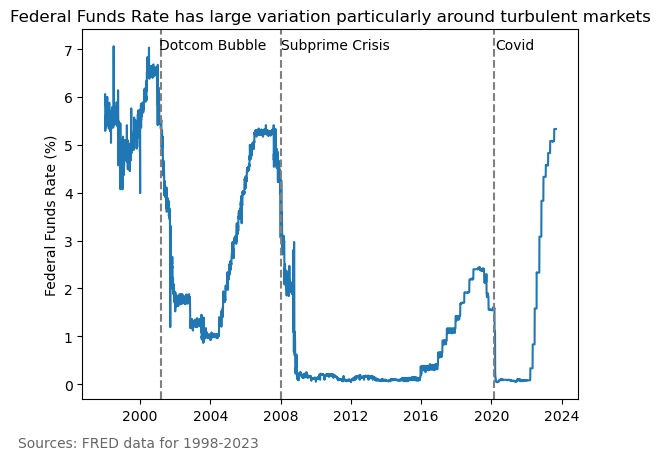

In [654]:
sns.lineplot(data=fed_df,x='Date',y='Measure')
plt.title('Federal Funds Rate has large variation particularly around turbulent markets')
plt.ylabel('Federal Funds Rate (%)')
plt.xlabel('')
plt.axvline(x=datetime.date(2008, 1, 1), color='gray', linestyle='--',label='Subprime Crisis')
plt.annotate('Subprime Crisis',xy=(datetime.date(2008, 1, 1),7))
#plt.annotate('Recession',xy=(2007,9),fontsize=11)
plt.axvline(x=datetime.date(2020, 3, 1), color='gray', linestyle='--',label='Covid')
plt.annotate('Covid',xy=(datetime.date(2020, 3, 17),7))
#plt.annotate('Covid',xy=(2020,9),fontsize=11)
plt.axvline(x=datetime.date(2001, 3, 1), color='gray', linestyle='--')
plt.annotate('Dotcom Bubble',xy=(datetime.date(2001, 2, 1),7))

plt.figtext(0.025, 0.01, 'Sources: FRED data for 1998-2023', fontsize=10, ha='left',alpha=0.6)
plt.show();

In [364]:
bls_subset = bls_data_df[['Date','year','Month_Num','value_num','Measure']]
bls_subset.loc[:,'Measure'] = bls_subset['Measure'].apply(lambda x: x.replace('Unemployment Rate','UNRATE'))
bls_subset.rename(columns = {'Measure':'Measure_Name','year':'Year','Date':'Month_Date','value_num':'Measure','Month_Num':'Month'}, inplace = True)
bls_subset.head(10)

/var/folders/d5/98xjjxvs53s2lf63ml40f_sc0000gn/T/ipykernel_13812/4024134323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_subset.loc[:,'Measure'] = bls_subset['Measure'].apply(lambda x: x.replace('Unemployment Rate','UNRATE'))
/var/folders/d5/98xjjxvs53s2lf63ml40f_sc0000gn/T/ipykernel_13812/4024134323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bls_subset.rename(columns = {'Measure':'Measure_Name','year':'Year','Date':'Month_Date','value_num':'Measure','Month_Num':'Month'}, inplace = True)


,Month_Date,Year,Month,Measure,Measure_Name
0,2003-12-01,2003,12,185.5,CPI
1,2003-11-01,2003,11,185.0,CPI
2,2003-10-01,2003,10,184.9,CPI
3,2003-09-01,2003,9,185.1,CPI
4,2003-08-01,2003,8,184.5,CPI
5,2003-07-01,2003,7,183.7,CPI
6,2003-06-01,2003,6,183.1,CPI
7,2003-05-01,2003,5,182.9,CPI
8,2003-04-01,2003,4,183.2,CPI
9,2003-03-01,2003,3,183.9,CPI


In [374]:
comb_df = pd.concat([bls_subset,fed_monthly]).reset_index()
comb_df['prior_value'] = comb_df.sort_values(['Measure_Name','Month_Date']).groupby('Measure_Name')['Measure'].shift(1)
comb_df.loc[:,'perc_chg'] = comb_df.apply(lambda row: 0.00 if pd.isna(row['prior_value']) else (row['Measure']-row['prior_value'])/row['prior_value'],axis=1)
comb_df.sort_values(['Measure_Name','Month_Date']).head()

,index,Month_Date,Year,Month,Measure,Measure_Name,prior_value,perc_chg
71,71,1998-01-01,1998,1,162.0,CPI,NaN,0.000000
70,70,1998-02-01,1998,2,162.0,CPI,162.0,0.000000
69,69,1998-03-01,1998,3,162.0,CPI,162.0,0.000000
68,68,1998-04-01,1998,4,162.2,CPI,162.0,0.001235
67,67,1998-05-01,1998,5,162.6,CPI,162.2,0.002466


In [624]:
inf_calc = bls_subset[((bls_subset['Month'].isin([1,12])) | 
            ((bls_subset['Year']=='2023') & (bls_subset['Month']==8))) & (bls_subset['Measure_Name']=='CPI')].sort_values('Month_Date',ascending=False)
inf_calc.loc[:,'beg_cpi'] = inf_calc.groupby(['Year'])['Measure'].shift(-1)
inf_calc.loc[:,'sa_inf_rate'] = inf_calc[~pd.isna(inf_calc['beg_cpi'])].apply(lambda row: 100*((row['Measure']-row['beg_cpi'])/row['beg_cpi']),axis=1)
inf_calc.sort_values(['Month_Date'],ascending=True).head()
#.groupby(['Measure_Name',bls_subset.Month_Date.rename("Year").dt.year])['Measure'].mean()

,Month_Date,Year,Month,Measure,Measure_Name,beg_cpi,sa_inf_rate
71,1998-01-01,1998,1,162.0,CPI,NaN,NaN
60,1998-12-01,1998,12,164.4,CPI,162.0,1.481481
59,1999-01-01,1999,1,164.7,CPI,NaN,NaN
48,1999-12-01,1999,12,168.8,CPI,164.7,2.489375
47,2000-01-01,2000,1,169.3,CPI,NaN,NaN


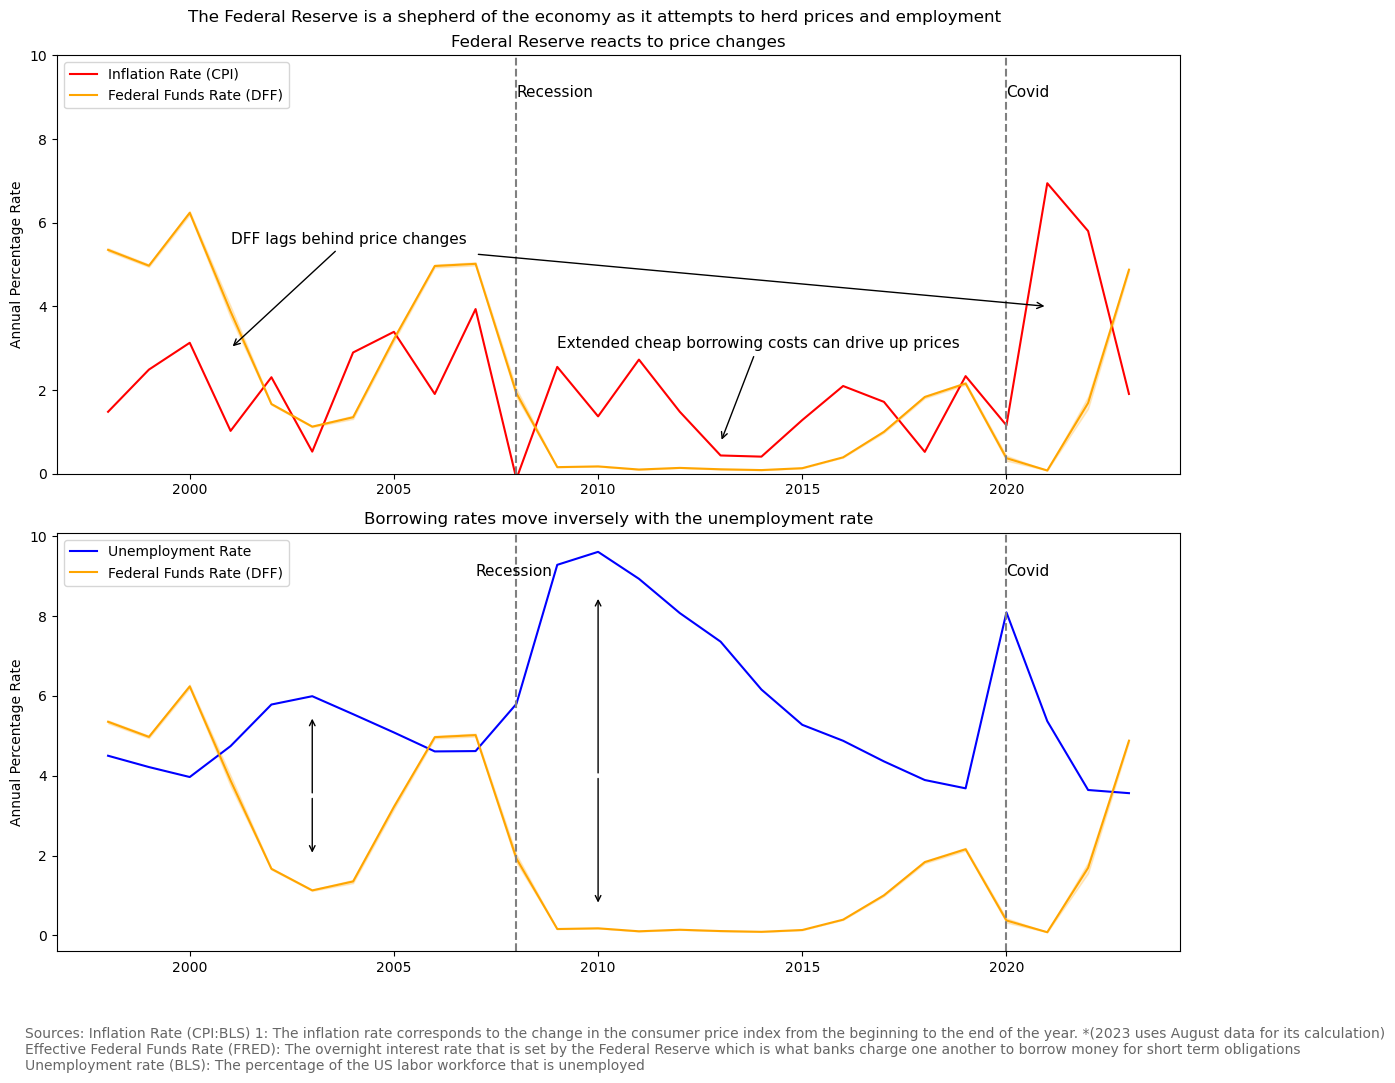

In [639]:
fig, (ax_line1,ax_line2) = plt.subplots(2,1,figsize=(12, 10))
sns.lineplot(data=inf_calc[~pd.isna(inf_calc['sa_inf_rate'])],x=inf_calc[~pd.isna(inf_calc['sa_inf_rate'])].Month_Date.dt.year,y='sa_inf_rate',color='red',errorbar=None,ax=ax_line1)
sns.lineplot(data=fed_df,x=fed_df.Date.dt.year,y='Measure',color='orange',ax=ax_line1)
leg1 = ax_line1.legend(labels=['Inflation Rate (CPI)','Federal Funds Rate (DFF)'])
leg1.legend_handles[0].set_color('red')
leg1.legend_handles[1].set_color('orange')
ax_line1.axvline(x=2008, color='gray', linestyle='--')
ax_line1.annotate('Recession',xy=(2008,9),fontsize=11)
ax_line1.axvline(x=2020, color='gray', linestyle='--')
ax_line1.annotate('Covid',xy=(2020,9),fontsize=11)
#ax_line1.axhline(y=inf_calc[~pd.isna(inf_calc['sa_inf_rate'])]['sa_inf_rate'].mean(),linestyle='--',)
sns.lineplot(data=bls_data_df[bls_data_df['Measure']=='Unemployment Rate'],x=bls_data_df[bls_data_df['Measure']=='Unemployment Rate'].Date.dt.year,y='value_num',color='blue',errorbar=None,ax=ax_line2)
sns.lineplot(data=fed_df,x=fed_df.Date.dt.year,y='Measure',color='orange',ax=ax_line2)
leg2= ax_line2.legend(labels=['Unemployment Rate','Federal Funds Rate (DFF)'])
leg2.legend_handles[0].set_color('blue')
leg2.legend_handles[1].set_color('orange')
ax_line2.axvline(x=2008, color='gray', linestyle='--')
ax_line2.axvline(x=2020, color='gray', linestyle='--')
ax_line2.annotate('Recession',xy=(2007,9),fontsize=11)
ax_line2.annotate('Covid',xy=(2020,9),fontsize=11)

ax_line1.axis(ymin=0,ymax=10)

ax_line1.set_xlabel('')
ax_line2.set_xlabel('')

ax_line1.set_ylabel('Annual Percentage Rate')
ax_line2.set_ylabel('Annual Percentage Rate')

ax_line1.set_title('Federal Reserve reacts to price changes')
#ax_line1.set
ax_line2.set_title('Borrowing rates move inversely with the unemployment rate')# set_title('Inverse Relationship')
fig.suptitle('The Federal Reserve is a shepherd of the economy as it attempts to herd prices and employment')

ax_line2.annotate('', xy=(2003, 5.5),xytext=(2003,3.5) ,arrowprops=dict(arrowstyle='->', color='black'))
ax_line2.annotate('', xy=(2003, 2),xytext=(2003,3.5) ,arrowprops=dict(arrowstyle='->', color='black'))
ax_line2.annotate('', xy=(2010, 8.5),xytext=(2010,4) ,arrowprops=dict(arrowstyle='->', color='black'))
ax_line2.annotate('', xy=(2010, 0.75),xytext=(2010,4) ,arrowprops=dict(arrowstyle='->', color='black'))
ax_line1.annotate('DFF lags behind price changes',xy=(2001,3),xytext=(2001,5.5),arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)
ax_line1.annotate('',xy=(2021,4),xytext=(2007,5.25),arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)
ax_line1.annotate('Extended cheap borrowing costs can drive up prices',xy=(2013,0.75),xytext=(2009,3),arrowprops=dict(arrowstyle='->', color='black'), fontsize=11)
caption = "Sources: Inflation Rate (CPI:BLS) 1: The inflation rate corresponds to the change in the consumer price index from the beginning to the end of the year. *(2023 uses August data for its calculation)\nEffective Federal Funds Rate (FRED): The overnight interest rate that is set by the Federal Reserve which is what banks charge one another to borrow money for short term obligations\nUnemployment rate (BLS): The percentage of the US labor workforce that is unemployed"

plt.figtext(0.025, -0.08, caption, fontsize=10, ha='left',alpha=0.6)
plt.tight_layout()
plt.show();